# Monte Carlo Hedge
1. Import the libraries
0. Define the parameters
1. Read the data
2. Simulate the prices
3. Calculate the g vector
4. Calculate the real option
5. Display and save the results

## 1. Introduction

### 1.2 Import the libraries

In [1]:
import os
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import custom modules
import src.read_data as rd
import src.simulations as sm
import src.g_functions as gf
import src.options as op
import src.visualization as vs
from src.export import export_figure, export_latex_table, export_params

# Plot styling
vs.set_professional_style()

### 1.3 Parameters

In [2]:
valuation_date = dt.datetime(2023, 1, 1)
data_path = 'C:/Users/fe_ma/Data'
optionality_window = 3 # In months
starting_valuation_window = 0 # In months
project_duration = 5 # years
rho = 0.05

days_in_month = (365*4 + 1) / 48

optionality_window *= days_in_month # converting to days
optionality_window = int(optionality_window)

starting_valuation_window *= days_in_month
starting_valuation_window = int(starting_valuation_window)

project_duration *= 12 * days_in_month
project_duration = int(project_duration)

other_parameters = {}
other_parameters['valuation_date'] = valuation_date
other_parameters['optionality_window'] = optionality_window
other_parameters['starting_valuation_window'] = starting_valuation_window
other_parameters['project_duration'] = project_duration

other_parameters['rho'] = rho

# 1. Define Projection Horizon
projection_horizon = optionality_window + project_duration + starting_valuation_window
other_parameters['projection_horizon'] = projection_horizon

## 2. Valuation Scenarios

To isolate the value of flexibility, we analyze the project under three distinct risk profiles. In all cases, the **Initial Investment (Capex)** is identical (we purchase the hardware), but the **Operational Risk** varies.

**1. The Deterministic Baseline (Static)**
* **Assumptions:** Bitcoin Price, Hashprice, and Electricity Cost remain constant at their $t=0$ values forever.
* **Goal:** Establishes the traditional NPV floor. It ignores all volatility.

**2. The "Hosting" Scenario (Fixed Cost, Stochastic Revenue)**
* **Assumptions:** Bitcoin/Hashprice follow a stochastic process (GBM). Electricity is **fixed** at the Hosting Rate ($0.065/kWh).
* **Flexibility:** We can pause mining if Hashprice drops too low, but we cannot benefit from cheap off-peak power.
* **Goal:** Quantifies the value of Bitcoin's upside volatility.

**3. The "Grid" Scenario (Stochastic Cost, Stochastic Revenue)**
* **Assumptions:** Both Bitcoin and Electricity are stochastic. We connect directly to the industrial grid (ERCOT).
* **Flexibility:** We gain the **"Spark Spread" option**: we mine when $Revenue > Cost$ and shut down during price spikes.
* **Goal:** Quantifies the additional value of managing energy volatility.

### 2.1. Case 1: Base Case - Deterministic Economics (Texas Scenario)

We establish a baseline for a 1 MW mining farm located in **West Texas**. This region is chosen for its abundant renewable energy and deregulated power grid (ERCOT).

**Assumptions:**
* **Location:** West Texas (e.g., Odessa/Midland area).
* **Hardware:** 350x Bitmain Antminer S19 XP (140 TH/s).
* **Electricity Rate:** $0.05 / kWh (Assumes a competitive industrial PPA).
* **Operational Expense (OpEx) Breakdown:**
    * **Rent:** Land lease for containerized setup.
    * **Labor:** 1 Full-time Site Technician (Texas avg. salary ~$52k/yr).
    * **Insurance:** Liability & Equipment coverage.
    * **Maintenance:** Consumables (filters, fans) and internet.

The goal is to calculate the **Daily Profit** and **Static Payback Period** under these specific local conditions.

In [3]:
import numpy as np
from src.export import export_params

# --- 1. The "Hybrid / Hosting" Setup ---
# Strategy: Buy the Hardware (Capex), Rent the Infrastructure (OpEx)

# A. Capex (The Hardware) -> K
# We assume a realistic market price for S19 XPs in a competitive market (~$18/TH)
n_miners = 350
miner_price = 2500           # Adjusted to reflect current market (lower than list price)
total_capex = n_miners * miner_price

# B. OpEx (The Hosting) -> kappa * Y + k
# "All-in" Hosting Rate covers Electricity, Rack Space, Security, IT, Insurance.
# Competitive North American rate: $0.065/kWh
hosting_rate_kwh = 0.065     

# Power Params
miner_power_w = 3010
total_power_kw = (n_miners * miner_power_w) / 1000

# KAPPA: Daily Energy Consumption (kWh/day)
# This converts Price ($/kWh) -> Daily Cost ($)
kappa = total_power_kw * 24 

# k: Daily Fixed Cost ($/day)
# In an "All-in" hosting model charged per kWh, fixed costs are 0 (fully variable).
# (Unless there is a minimum shelf rent, but we assume pure hosting here)
k = 0 

monthly_hosting_cost = total_power_kw * 24 * days_in_month * hosting_rate_kwh

# --- 2. Monthly Economics ---
current_hashprice = 45.0     # $/PH/Day
total_hashrate_ph = (n_miners * 140) / 1000
monthly_revenue = total_hashrate_ph * current_hashprice * days_in_month

# Net Monthly Profit
net_monthly_profit = monthly_revenue - monthly_hosting_cost

# --- 3. Return Metrics ---
monthly_margin_pct = (net_monthly_profit / monthly_revenue) * 100
payback_months = total_capex / net_monthly_profit if net_monthly_profit > 0 else 999
payback_years = payback_months / 12

# --- 4. Store Investment Parameters for Simulations ---
# We bundle these for easy use in the Real Options functions later
investment_parameters = {
    'K': total_capex,        # Initial Investment
    'k': k,                  # Daily Fixed Cost
    'kappa': kappa,          # Energy Conversion (kWh/day)
    'hashrate': total_hashrate_ph # Stored to scale revenue later
}

# --- Print Results ---
print(f"--- Hybrid 'Hosting' Model ---")
print(f"Initial Capex (K):   ${total_capex:,.0f}")
print(f"Kappa (kWh/day):     {kappa:,.1f}")
print(f"Fixed Cost (k):      ${k:,.0f}")
print(f"Monthly Revenue:     ${monthly_revenue:,.2f}")
print(f"Monthly Hosting:     ${monthly_hosting_cost:,.2f} (@ {hosting_rate_kwh*100}c/kWh)")
print(f"Net Monthly Profit:  ${net_monthly_profit:,.2f}")
print(f"Payback Period:      {payback_years:.1f} Years")

# --- Export to LaTeX ---
hybrid_vars = {
    "HybridCapex": f"{total_capex:,.0f}",
    "HybridMinerPrice": f"{miner_price:,.0f}",
    "HybridHostingRate": f"{hosting_rate_kwh:.3f}",
    "HybridMonthlyProfit": f"{net_monthly_profit:,.0f}",
    "HybridPayback": f"{payback_years:.1f}",
    "Kappa": f"{kappa:,.0f}"
}
export_params(hybrid_vars, "hybrid_economics")

--- Hybrid 'Hosting' Model ---
Initial Capex (K):   $875,000
Kappa (kWh/day):     25,284.0
Fixed Cost (k):      $0
Monthly Revenue:     $67,114.69
Monthly Hosting:     $50,022.81 (@ 6.5c/kWh)
Net Monthly Profit:  $17,091.87
Payback Period:      4.3 Years
  → Saved params: c:\Users\fe_ma\Projects\MonteCarloHedge\results\hybrid_economics.json
  → Saved macros: c:\Users\fe_ma\Projects\MonteCarloHedge\results\tables\hybrid_economics_macros.tex


('c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\hybrid_economics.json',
 'c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\tables\\hybrid_economics_macros.tex')

In [4]:
print('project revenue: ', int(project_duration / days_in_month * monthly_revenue))
print('project cost: ', int(project_duration / days_in_month * monthly_hosting_cost))
print('project profit: ', int(project_duration / days_in_month * (monthly_revenue - monthly_hosting_cost)))
print('vpn: ', int(project_duration / days_in_month * (monthly_revenue - monthly_hosting_cost)- total_capex))



project revenue:  4026330
project cost:  3000957
project profit:  1025372
vpn:  150372


#### 2.1.2 Project Value with Exit Strategy

  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\pv_exit_curve_static.pdf
  → Saved params: c:\Users\fe_ma\Projects\MonteCarloHedge\results\static_exit_analysis.json
  → Saved macros: c:\Users\fe_ma\Projects\MonteCarloHedge\results\tables\static_exit_analysis_macros.tex
Optimal Stopping Time (Deterministic): Month 60
Max Project Value: $89,585.88


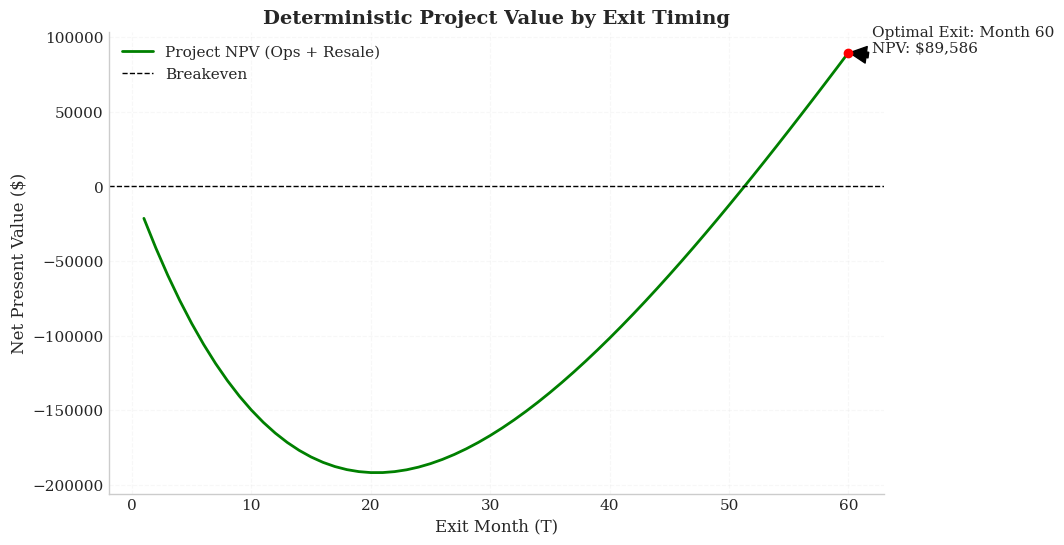

In [5]:
# --- Deterministic Project Value with Exit Strategy ---

# We assume the 'net_monthly_profit' calculated in the Base Case remains constant
n_months_proj = 5 * 12
projected_cfs = np.full(n_months_proj, net_monthly_profit)

# 2. Depreciation Parameters
# FIX: Use 'miner_price' instead of 'miner_cost'
miner_capex = n_miners * miner_price 
infra_capex = total_capex - miner_capex # This will be 0 in the Hybrid model, which is correct

depreciation_miner_monthly = 0.04  # 4% value loss per month
depreciation_infra_monthly = 0.01  # 1% value loss per month

possible_exits = np.arange(1, n_months_proj + 1)
pv_exit_curve = []

# Monthly Discount Rate (derived from annual rho)
# Fallback to 0.05 if other_params is not defined from previous cells
r_annual = other_params['rho'] if 'other_params' in locals() else 0.05
r_monthly = r_annual / 12

for T in possible_exits:
    # A. Discounted Cash Flows from operations (t=1 to T)
    cfs = projected_cfs[:T]
    discounts = (1 + r_monthly) ** np.arange(1, T + 1)
    pv_operations = np.sum(cfs / discounts)
    
    # B. Salvage Value at T (Discounted back to t=0)
    # Remaining Book Value
    rem_value_miners = miner_capex * ((1 - depreciation_miner_monthly) ** T)
    rem_value_infra = infra_capex * ((1 - depreciation_infra_monthly) ** T)
    salvage_value = rem_value_miners + rem_value_infra
    
    # Discount the salvage value received at time T
    pv_salvage = salvage_value / ((1 + r_monthly) ** T)
    
    # C. Total Project NPV if we stop at T
    total_npv = pv_operations + pv_salvage - total_capex
    pv_exit_curve.append(total_npv)

pv_exit_curve = np.array(pv_exit_curve)

# 3. Find Optimal Static Exit
optimal_exit_month = np.argmax(pv_exit_curve) + 1 
max_project_value = pv_exit_curve[optimal_exit_month - 1]
vs.plot_project_value(possible_exits, pv_exit_curve, max_project_value, optimal_exit_month)


exit_vars = {
    "StaticExitMonth": f"{optimal_exit_month}",
    "StaticMaxPV": f"{max_project_value:,.0f}",
    "SalvageDeprRate": f"{depreciation_miner_monthly*100:.0f}\\%"
}
export_params(exit_vars, "static_exit_analysis")

print(f"Optimal Stopping Time (Deterministic): Month {optimal_exit_month}")
print(f"Max Project Value: ${max_project_value:,.2f}")

### 2. Stochastic Revenue: The "Hosting" Case

In this scenario, we isolate the value of **Revenue Volatility**.

**The Setup:**
* **Cost Structure:** We pay a fixed hosting rate ($0.065/kWh). This removes energy price risk but retains the obligation to pay for rack space.
* **Revenue Structure:** We are fully exposed to the volatility of **Bitcoin Price ($X_t$)** and **Hashprice ($Z_t$)**.
* **The Option:** The "Switching Option" here is the ability to turn off miners if the Hashprice drops below the hosting cost break-even point.

Before valuing this option, we must analyze the historical behavior of $X_t$ and $Z_t$ and simulate their future paths to ensure our model captures the "Crypto Winter" and "Bull Run" dynamics correctly.


#### 2.1 Read Data

In [6]:
df_data = rd.read_data(data_path=data_path, is_electricity_constant=True)

In [ ]:
# Load Data (Now with Yahoo Finance online fetching enabled)
# Start date is set, end_date=None means it will fetch up to "Today"
df_data = rd.read_data(
    data_path=data_path, 
    is_electricity_constant=False, 
    use_online_data=True,         # Set to False if you want to use purely local CSVs again
    start_date='2020-01-01'       # Adjust as needed to match your Hashprice CSV
)

# Filter for Training Period (Ensure valuation_date is set properly)
valuation_date = df_data.index[-1] # Automatically set valuation to the most recent day downloaded
n_train_days = 1000

df_train = df_data[valuation_date - dt.timedelta(days=n_train_days): valuation_date]
print(f"Loaded {len(df_train)} days of market data ending on {valuation_date.date()}")

In [7]:
n_simulations = 200
n_days_forecast = other_parameters['projection_horizon']

n_train_days = 5 * 365 

Index(['hashprice', 'btc'], dtype='object')
True
  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\historical_bitcoin_dual.pdf


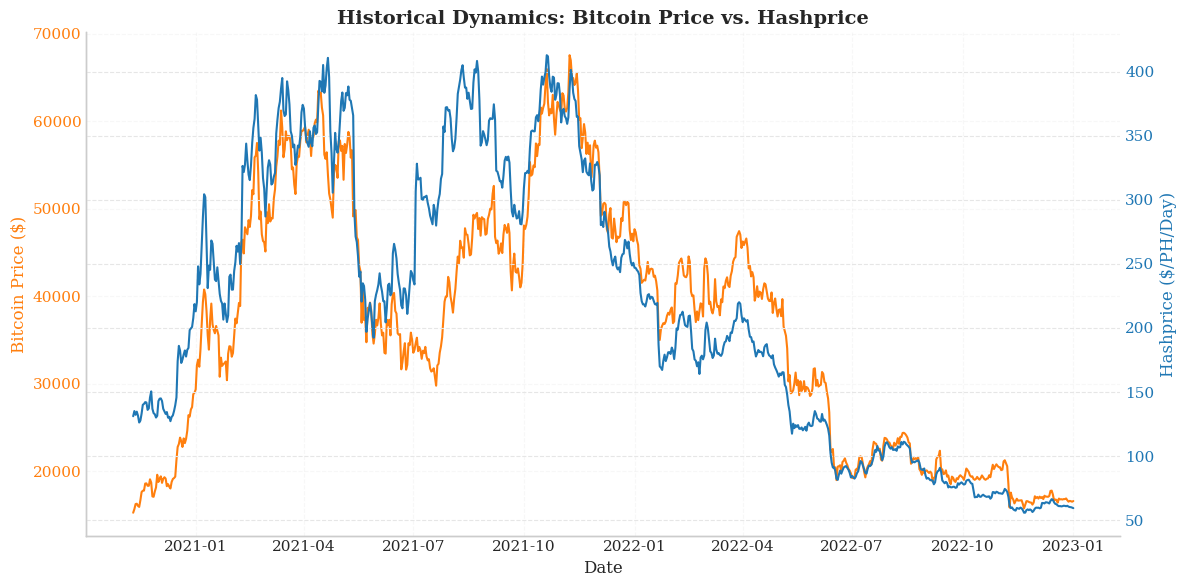

In [8]:
# --- 1. Load & Analyze Historical Data ---
# We load the data to calibrate our simulation
df_data = rd.read_data(data_path=data_path, is_electricity_constant=True)

# Filter for the training period (Calibration Window)
# We use the last N days to capture recent volatility regimes
df_train = df_data[valuation_date - dt.timedelta(days=n_train_days): valuation_date].copy()
vs.plot_prices(df_train)

In [9]:
# B. Correlation Analysis
# We need to see how tightly coupled they are (usually high correlation)
log_returns = np.log(df_train).diff().dropna()
corr_matrix = log_returns.corr()
btc_hash_corr = corr_matrix.loc['btc', 'hashprice']

print(f"--- Data Analysis ---")
print(f"Correlation (BTC vs Hashprice): {btc_hash_corr:.4f}")
print(f"Annual Volatility (BTC):       {log_returns['btc'].std() * np.sqrt(365):.2%}")
print(f"Annual Volatility (Hashprice): {log_returns['hashprice'].std() * np.sqrt(365):.2%}")

# Export Calibration Stats
stats_vars = {
    "CorrBTCHash": f"{btc_hash_corr:.2f}",
    "VolBTC": f"{log_returns['btc'].std() * np.sqrt(365):.1%}",
    "VolHash": f"{log_returns['hashprice'].std() * np.sqrt(365):.1%}"
}
export_params(stats_vars, "revenue_calibration")

--- Data Analysis ---
Correlation (BTC vs Hashprice): 0.4937
Annual Volatility (BTC):       72.56%
Annual Volatility (Hashprice): 74.85%
  → Saved params: c:\Users\fe_ma\Projects\MonteCarloHedge\results\revenue_calibration.json
  → Saved macros: c:\Users\fe_ma\Projects\MonteCarloHedge\results\tables\revenue_calibration_macros.tex


('c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\revenue_calibration.json',
 'c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\tables\\revenue_calibration_macros.tex')

#### 2.2 Simulations

In [10]:
# --- 2. Simulation (Stochastic Revenue) ---
# We simulate thousands of potential future paths for X and Z

# Calibrate Multivariate GBM Parameters
multi_params = sm.calculate_multivariate_params(log_returns)

# Run Simulation
# We assume Electricity is constant (not simulated here, or simulated but ignored later)
# The simulation function returns a dictionary of paths (N_sims x N_days)
print(f"\nSimulating {n_simulations} paths over {n_days_forecast} days...")
sim_results = sm.simulate_multivariate_with_electricity(
    multivariate_params=multi_params,
    n_days=n_days_forecast,
    electricity_params=None, # Electricity not needed for this step (or handled separately)
    n_simulations=n_simulations,
    start_date=valuation_date
)
price_simulations = sm.convert_to_price(sim_results, df_train)


Simulating 200 paths over 1917 days...


  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\simulated_revenue_paths.pdf


'c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\figures\\simulated_revenue_paths.pdf'

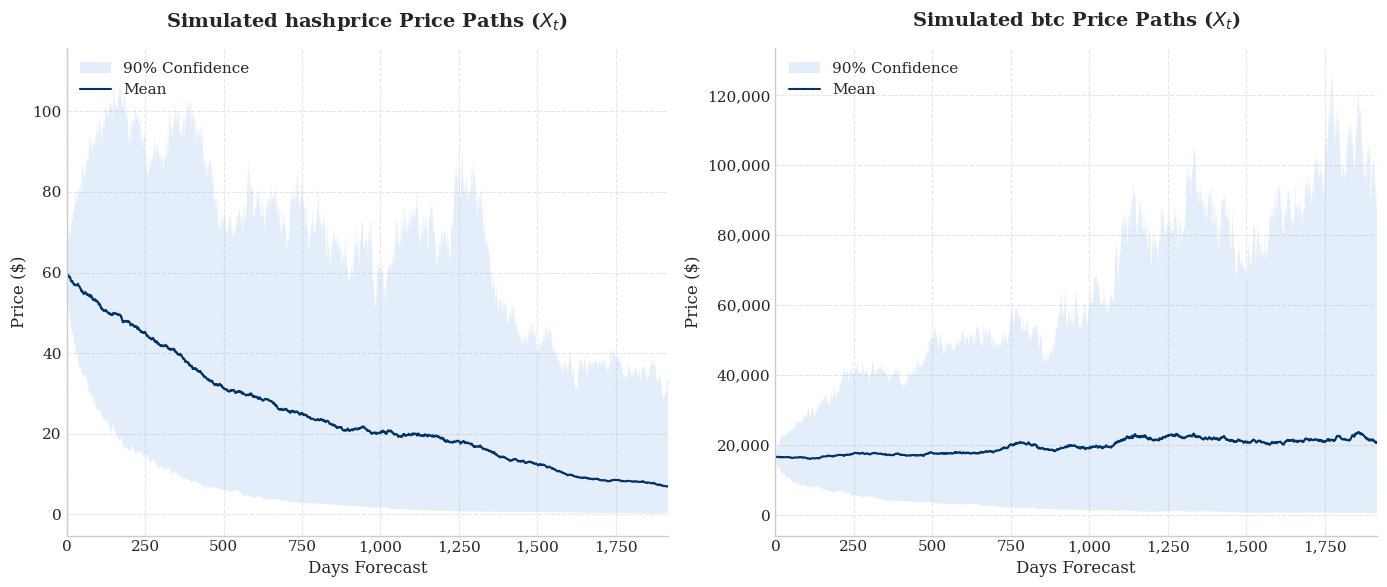

In [11]:
# Convert log-returns to Price Paths
projection_horizon = other_parameters['projection_horizon']
list_dates = list_dates = [valuation_date + dt.timedelta(days=i) for i in range(projection_horizon + 1)]

prices = {}
for name, price in price_simulations.items():
    prices[name] = pd.DataFrame(price_simulations[name], columns=list_dates)

# --- 3. Visualization: Simulation Fan Charts ---
# We plot the 50% (median) and 90% confidence intervals to show the risk range.

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, name in enumerate(prices):
    # Plot BTC Simulation
    vs.plot_distribution(
        x_values=np.arange(n_days_forecast + 1),
        data=prices[name],
        title=f"Simulated {name} Price Paths ($X_t$)",
        ylabel="Price ($)",
        xlabel="Days Forecast",
        ax=axes[i]
    )

plt.tight_layout()
export_figure(fig, "simulated_revenue_paths")

Parameters

In [12]:
# We use a constant scalar for Y
fixed_elec_price = hosting_rate_kwh # e.g. 0.065
prices['electricity'] = fixed_elec_price
other_parameters['n_days_forecast'] = projection_horizon
other_parameters['delta_time'] = 1 / 365.25


#### 2.3 Calculate G function

In [13]:
if 'hashprice' in prices:
    prices['hashprice'] *= total_hashrate_ph


In [14]:
project_duration = other_parameters['project_duration']

kappa = investment_parameters['kappa']
k = investment_parameters['k']
K = investment_parameters['K']

result_aux = prices['hashprice'] - kappa * prices['electricity'] - k
result_aux = result_aux.T
result_aux[result_aux < 0] = 0
result_aux -= k
result_total = result_aux.rolling(project_duration).sum()
result_total = result_total.shift(-project_duration)
result_total.dropna(inplace=True)

# result_total
# (result_total - K).dropna().plot(legend=False)
# (result_total - K).T.describe()
(result_total).T.describe()


# result_aux
# result_aux.T.plot(legend=False)

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08,2023-01-09,2023-01-10,...,2023-03-24,2023-03-25,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,...,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
mean,7.462410e+05,7.450369e+05,7.438311e+05,7.426348e+05,7.414427e+05,7.402488e+05,7.390628e+05,7.378915e+05,7.367213e+05,7.355518e+05,...,6.592053e+05,6.582552e+05,6.572986e+05,6.563536e+05,6.554005e+05,6.544444e+05,6.534886e+05,6.525285e+05,6.515731e+05,6.506319e+05
std,1.535343e+06,1.535566e+06,1.535798e+06,1.536044e+06,1.536269e+06,1.536497e+06,1.536719e+06,1.536939e+06,1.537156e+06,1.537368e+06,...,1.541522e+06,1.541374e+06,1.541211e+06,1.541022e+06,1.540839e+06,1.540631e+06,1.540417e+06,1.540199e+06,1.539984e+06,1.539783e+06
min,1.796721e+04,1.689303e+04,1.577413e+04,1.471572e+04,1.377743e+04,1.288319e+04,1.196137e+04,1.093072e+04,1.004794e+04,9.255582e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.195046e+05,1.181591e+05,1.166581e+05,1.151572e+05,1.138071e+05,1.125167e+05,1.114180e+05,1.104214e+05,1.092202e+05,1.078226e+05,...,4.758097e+04,4.689558e+04,4.592214e+04,4.525325e+04,4.478382e+04,4.413636e+04,4.358805e+04,4.253832e+04,4.157950e+04,4.078901e+04
50%,2.848204e+05,2.836054e+05,2.824543e+05,2.813564e+05,2.798749e+05,2.782633e+05,2.766757e+05,2.750382e+05,2.734002e+05,2.717465e+05,...,1.856328e+05,1.851605e+05,1.847454e+05,1.842811e+05,1.839684e+05,1.835790e+05,1.825600e+05,1.815226e+05,1.803388e+05,1.791069e+05
75%,7.342344e+05,7.329547e+05,7.315456e+05,7.301404e+05,7.287268e+05,7.272687e+05,7.259343e+05,7.245946e+05,7.232092e+05,7.220311e+05,...,6.441443e+05,6.429373e+05,6.416920e+05,6.403634e+05,6.389536e+05,6.375228e+05,6.361344e+05,6.347375e+05,6.333110e+05,6.319100e+05
max,1.522199e+07,1.522168e+07,1.522128e+07,1.522112e+07,1.522070e+07,1.522044e+07,1.522016e+07,1.521993e+07,1.521967e+07,1.521935e+07,...,1.520480e+07,1.520418e+07,1.520361e+07,1.520280e+07,1.520193e+07,1.520096e+07,1.519980e+07,1.519854e+07,1.519718e+07,1.519591e+07


In [ ]:
# 3. Estimate G-Function Coefficients (Alpha)
# This trains the model to understand how daily profit maps to long-term NPV
print("Estimating G-Function Coefficients (Project Value Mapping)...")

g_alpha = gf.estimate_g_alpha(
    prices=prices,
    # dates_parameters=other_parameters,
    investment_parameters=investment_parameters,
    other_parameters=other_parameters,
    n_simulations=100
)

print(f"G-Function Alphas: {g_alpha.flatten()}")

Estimating G-Function Coefficients (Project Value Mapping)...
G-Function Alphas: [[-5.74531840e+05  1.40996549e+02  1.26327680e-01  2.29433031e-05]]


In [16]:
import src.options as op
import src.g_functions as gf

# Select a date to evaluate (e.g., the valuation date from your other_parameters)
test_date = other_parameters['valuation_date']

# Reformat the prices structure for that specific date so it works with the function
df_prices_g = op.obtain_prices(prices, test_date)

# Calculate the g_tilde results using the already estimated g_alpha coefficients
g_tilde_results = gf.calculate_g_tilde(df_prices_g, investment_parameters['kappa'], g_alpha)

print(f"g_tilde results for {test_date.date()}:")
# Display the first few rows of the calculation for review
display(g_tilde_results.to_frame(name='g_tilde').head())


g_tilde results for 2023-01-01:


,g_tilde
0,-145791.903426
1,-145791.903426
2,-145791.903426
3,-145791.903426
4,-145791.903426


#### 2.4 Real Option Value

In [17]:
# 4. Run Real Option Valuation (LSMC)
print("Calculating Real Option Value (Fixed Power Cost)...")
dates_window = [valuation_date + dt.timedelta(days=i) for i in range(n_days_forecast + 1)]
basis_config = {'pol_order': 2, 'option_basis': 'black-scholes'}
results_fixed = op.calculate_real_option(
    prices=prices, 
    other_parameters=other_parameters,
    investment_parameters=investment_parameters,
    basis_type=basis_config,
    g_alpha=g_alpha
)

Calculating Real Option Value (Fixed Power Cost)...
--------------------
[datetime.datetime(2023, 1, 1, 0, 0), datetime.datetime(2023, 1, 31, 0, 0), datetime.datetime(2023, 3, 2, 0, 0), datetime.datetime(2023, 4, 2, 0, 0)]
[datetime.datetime(2023, 1, 1, 0, 0), datetime.datetime(2023, 1, 31, 0, 0), datetime.datetime(2023, 3, 2, 0, 0)]
--------------------
date 2023-03-02 00:00:00
date 2023-01-31 00:00:00
   call_po_0  call_po_1_btc  call_po_2_btc  call_option  dl_po_0_btc  \
0          1    -844.061910   7.124405e+05  4856.775626 -1930.923617   
1          1      86.454842   7.474440e+03  5466.403277 -2502.949088   
2          1    -267.181272   7.138583e+04  5231.961420   238.306636   
3          1    3055.338841   9.335095e+06  7553.287283  1399.021136   
4          1    3158.256475   9.974584e+06  7629.059149 -2467.383167   

    dl_po_1_btc  dl_option_btc  
0  1.629819e+06   -1240.326463  
1 -2.163921e+05   -1670.948564  
2 -6.367107e+04     156.865559  
3  4.274484e+06    1028.5866

#### 2.5 Results

  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\ro_value_fixed_cost.pdf
  → Saved params: c:\Users\fe_ma\Projects\MonteCarloHedge\results\ro_results_fixed.json
  → Saved macros: c:\Users\fe_ma\Projects\MonteCarloHedge\results\tables\ro_results_fixed_macros.tex
--- Results (Fixed Power) ---
Real Option Value: $165,027
Intrinsic NPV:     $0
Option Premium:    $165,027 (Value of Flexibility)


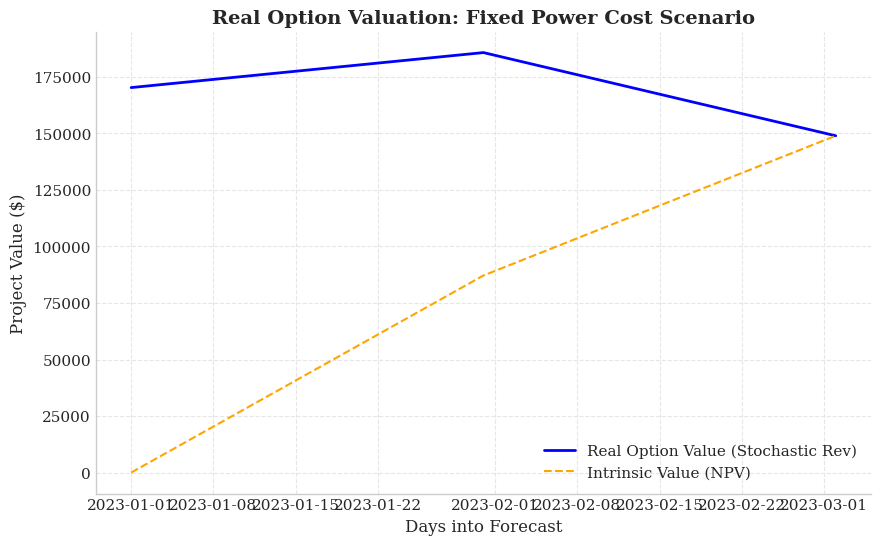

In [18]:
df_ro_fixed = results_fixed[0] # Option Value
df_int_fixed = results_fixed[2] # Intrinsic Value (NPV)

# 5. Visualize Results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Mean Option Value vs Mean Intrinsic Value over time
ax.plot(df_ro_fixed.mean(axis=0), label="Real Option Value (Stochastic Rev)", color='blue', linewidth=2)
ax.plot(df_int_fixed.mean(axis=0), label="Intrinsic Value (NPV)", color='orange', linestyle='--')

ax.set_title("Real Option Valuation: Fixed Power Cost Scenario")
ax.set_ylabel("Project Value ($)")
ax.set_xlabel("Days into Forecast")
ax.legend()

export_figure(fig, "ro_value_fixed_cost")

# 6. Export Key Metrics
ro_val_t0 = df_ro_fixed.iloc[0, 0]
int_val_t0 = df_int_fixed.iloc[0, 0]
option_premium = ro_val_t0 - int_val_t0

fixed_cost_results = {
    "FixedPowerROValue": f"{ro_val_t0:,.0f}",
    "FixedPowerNPV": f"{int_val_t0:,.0f}",
    "FixedPowerPremium": f"{option_premium:,.0f}"
}
export_params(fixed_cost_results, "ro_results_fixed")

print(f"--- Results (Fixed Power) ---")
print(f"Real Option Value: ${ro_val_t0:,.0f}")
print(f"Intrinsic NPV:     ${int_val_t0:,.0f}")
print(f"Option Premium:    ${option_premium:,.0f} (Value of Flexibility)")


### 3. Full Stochastic: Revenue and Cost

#### 3.1 Read Data

In [19]:
df_data = rd.read_data(data_path=data_path, is_electricity_constant=False)

In [20]:
# df_data

In [21]:
n_simulations = 500
n_days_forecast = other_parameters['projection_horizon']

n_train_days = 5 * 365 

In [22]:
df_data.describe()

,hashprice,btc,electricity
count,1290.000000,1290.000000,1290.000000
mean,160.523667,36838.224905,81.255599
std,108.337839,14557.031012,467.298835
min,45.260000,15290.902344,7.644063
25%,75.460000,25070.760743,23.945456
50%,104.640000,34700.435547,33.197917
75%,234.097500,46620.165039,52.396328
max,412.850000,73083.500000,8837.032708


Index(['hashprice', 'btc', 'electricity'], dtype='object')
True
  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\historical_electricity_dual.pdf


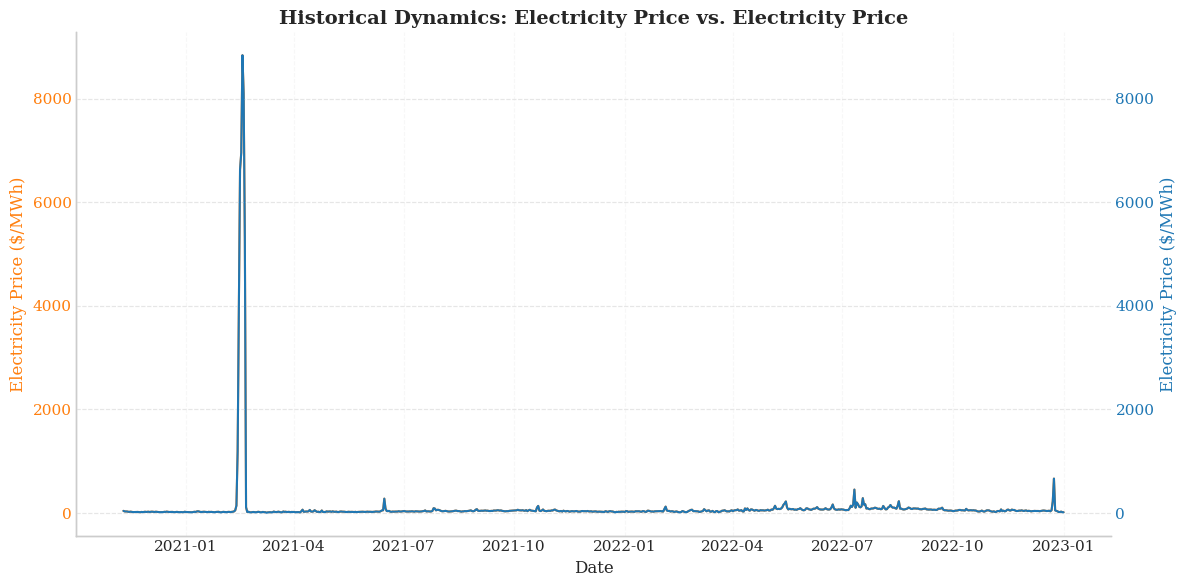

In [23]:
# --- 1. Load & Analyze Historical Data ---
# We load the data to calibrate our simulation

# Filter for the training period (Calibration Window)
# We use the last N days to capture recent volatility regimes
df_train = df_data[valuation_date - dt.timedelta(days=n_train_days): valuation_date].copy()
vs.plot_prices(df_train, assets_type='electricity')

In [24]:
# B. Correlation Analysis
# We need to see how tightly coupled they are (usually high correlation)
df_data_ret = np.log(df_train)
df_data_ret[['hashprice', 'btc']] = df_data_ret[['hashprice', 'btc']].diff()
df_data_ret.dropna(inplace=True)

corr_matrix = df_data_ret.corr()

assets = ['btc', 'hashprice']

corr = corr_matrix.loc[assets[0], assets[1]]

print(f"--- Data Analysis ---")
print(f"Correlation ({assets[0].capitalize()} vs {assets[1].capitalize()}): {corr:.4f}")
print(f"Annual Volatility ({assets[0].capitalize()}):       {df_data_ret[assets[0]].std() * np.sqrt(365):.2%}")
print(f"Annual Volatility ({assets[1].capitalize()}): {df_data_ret[assets[1]].std() * np.sqrt(365):.2%}")

# Export Calibration Stats
stats_vars = {
    "CorrBTCHash": f"{corr:.2f}",
    "VolBTC": f"{df_data_ret[assets[0]].std() * np.sqrt(365):.1%}",
    "VolHash": f"{df_data_ret[assets[1]].std() * np.sqrt(365):.1%}"
}
export_params(stats_vars, "revenue_calibration")

--- Data Analysis ---
Correlation (Btc vs Hashprice): 0.4937
Annual Volatility (Btc):       72.56%
Annual Volatility (Hashprice): 74.85%
  → Saved params: c:\Users\fe_ma\Projects\MonteCarloHedge\results\revenue_calibration.json
  → Saved macros: c:\Users\fe_ma\Projects\MonteCarloHedge\results\tables\revenue_calibration_macros.tex


('c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\revenue_calibration.json',
 'c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\tables\\revenue_calibration_macros.tex')

#### 3.2 Simulations

In [25]:
# --- 2. Simulation (Stochastic Revenue) ---
# We simulate thousands of potential future paths for X and Z

# Calibrate Multivariate GBM Parameters
# fit_models = {'hashprice': 'brownian', 'btc': 'brownian', 'electricity': 'fit_electricity'}

multi_params = sm.calculate_multivariate_params(df_data_ret)
df_electricity, electricity_params = sm.fit_electricity(df_data_ret)

# Run Simulation
# We assume Electricity is constant (not simulated here, or simulated but ignored later)
# The simulation function returns a dictionary of paths (N_sims x N_days)
print(f"\nSimulating {n_simulations} paths over {n_days_forecast} days...")
sim_results = sm.simulate_multivariate_with_electricity(
    multivariate_params=multi_params,
    n_days=n_days_forecast,
    electricity_params=electricity_params, 
    n_simulations=n_simulations,
    start_date=valuation_date
)
price_simulations = sm.convert_to_price(sim_results, df_train)


Simulating 500 paths over 1917 days...


  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\simulated_revenue_paths.pdf


'c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\figures\\simulated_revenue_paths.pdf'

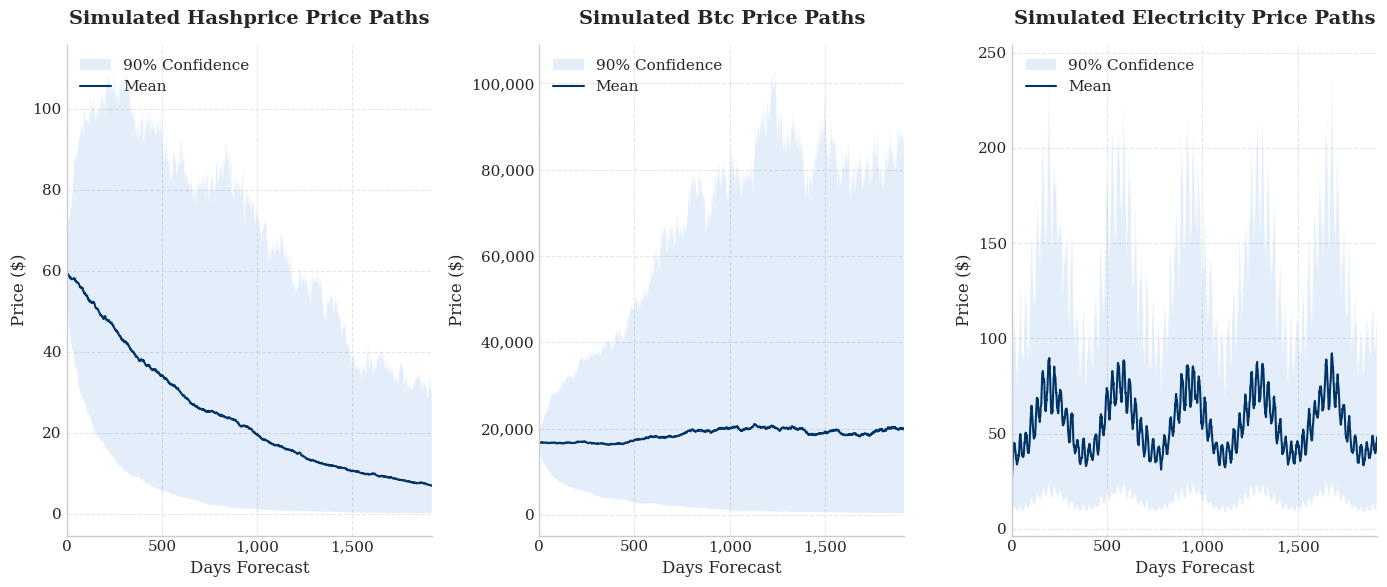

In [26]:
# Convert log-returns to Price Paths
projection_horizon = other_parameters['projection_horizon']
list_dates = list_dates = [valuation_date + dt.timedelta(days=i) for i in range(projection_horizon + 1)]

prices = {}
for name, price in price_simulations.items():
    prices[name] = pd.DataFrame(price_simulations[name], columns=list_dates)

# --- 3. Visualization: Simulation Fan Charts ---
# We plot the 50% (median) and 90% confidence intervals to show the risk range.

fig, axes = plt.subplots(1, len(prices), figsize=(14, 6))

for i, name in enumerate(prices):
    # Plot BTC Simulation
    # print('-'*20 + name + '-'*20)
    # print(prices[name].describe())

    # print(name, prices[name].head())
    vs.plot_distribution(
        x_values=np.arange(n_days_forecast + 1),
        data=prices[name],
        title=f"Simulated {name.capitalize()} Price Paths",
        ylabel="Price ($)",
        xlabel="Days Forecast",
        ax=axes[i]
    )

plt.tight_layout()
export_figure(fig, "simulated_revenue_paths")

Parameters

In [27]:
other_parameters['n_days_forecast'] = projection_horizon
other_parameters['delta_time'] = 1 / 365.25

#### 3.3 Calculate G function

In [28]:
if 'hashprice' in prices:
    prices['hashprice'] *= total_hashrate_ph

if 'electricity' in prices:
    prices['electricity'] /= 10000

In [29]:
# 3. Estimate G-Function Coefficients (Alpha)
# This trains the model to understand how daily profit maps to long-term NPV
print("Estimating G-Function Coefficients (Project Value Mapping)...")

g_alpha = gf.estimate_g_alpha(
    prices=prices,
    # dates_parameters=other_parameters,
    investment_parameters=investment_parameters,
    other_parameters=other_parameters,
    n_simulations=200
)

print(f"G-Function Alphas: {g_alpha.flatten()}")

Estimating G-Function Coefficients (Project Value Mapping)...
G-Function Alphas: [[ 7.32287614e+04 -8.05798454e+02  5.34269549e-01 -3.77985030e-05]]


In [30]:
import src.options as op
import src.g_functions as gf

# Select a date to evaluate (e.g., the valuation date from your other_parameters)
test_date = other_parameters['valuation_date']

# Reformat the prices structure for that specific date so it works with the function
df_prices_g = op.obtain_prices(prices, test_date)

# Calculate the g_tilde results using the already estimated g_alpha coefficients
g_tilde_results = gf.calculate_g_tilde(df_prices_g, investment_parameters['kappa'], g_alpha)

print(f"g_tilde results for {test_date.date()}:")
# Display the first few rows of the calculation for review
display(g_tilde_results.to_frame(name='g_tilde').head())


g_tilde results for 2023-01-01:


,g_tilde
0,1.267479e+06
1,1.267479e+06
2,1.267479e+06
3,1.267479e+06
4,1.267479e+06


In [31]:
# Calculate g_tilde across the entire price path dataframe using broadcasting
v = prices['hashprice'] - investment_parameters['kappa'] * prices['electricity']
g_tilde_all = g_alpha[0].item() + g_alpha[1].item() * v + g_alpha[2].item() * v**2 + g_alpha[3].item() * v**3

print("g_tilde results across all paths:")
display(g_tilde_all.head())


g_tilde results across all paths:


,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08,2023-01-09,2023-01-10,...,2028-03-23,2028-03-24,2028-03-25,2028-03-26,2028-03-27,2028-03-28,2028-03-29,2028-03-30,2028-03-31,2028-04-01
0,1.267479e+06,1.275786e+06,1.401141e+06,1.496236e+06,1.552188e+06,1.237271e+06,1.388534e+06,1.587035e+06,1.785537e+06,1.862377e+06,...,139853.549476,48070.037949,83279.011780,116069.119654,66128.582690,45204.345624,46038.107275,52752.057890,25649.421190,70849.076502
1,1.267479e+06,1.039579e+06,1.059263e+06,1.043006e+06,1.065856e+06,1.097456e+06,9.914324e+05,7.122553e+05,6.363303e+05,7.490569e+05,...,169518.225326,188269.873389,150911.733884,181782.506288,146613.470343,196562.114517,222620.015561,205457.435604,237636.831947,236021.951843
2,1.267479e+06,1.167036e+06,1.080450e+06,9.855197e+05,9.092971e+05,8.212717e+05,6.989317e+05,7.601555e+05,6.507889e+05,5.709254e+05,...,-195947.015978,-205150.323186,-199180.083187,-217906.933908,-219750.311733,-231164.547951,-219636.778064,-228646.191650,-226682.574753,-234487.730982
3,1.267479e+06,1.081764e+06,1.277309e+06,1.186133e+06,1.397264e+06,1.169486e+06,1.012573e+06,1.235733e+06,1.471255e+06,1.574610e+06,...,13470.272800,14700.296360,-983.704361,-412.302947,-5187.834343,8796.634609,3608.570259,6634.464946,4725.663315,19021.515603
4,1.267479e+06,1.313921e+06,1.419409e+06,1.357575e+06,1.080177e+06,1.062302e+06,9.373493e+05,9.267228e+05,8.845146e+05,9.481694e+05,...,12837.235656,19708.777404,19975.240658,29114.699047,24721.316950,20079.589629,31803.370763,40371.956436,51786.572831,51348.940696


#### 3.4 Real Option Value

In [17]:
prices['electricity']

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08,2023-01-09,2023-01-10,...,2028-03-23,2028-03-24,2028-03-25,2028-03-26,2028-03-27,2028-03-28,2028-03-29,2028-03-30,2028-03-31,2028-04-01
0,0.001653,0.003079,0.002468,0.003100,0.002413,0.005046,0.005726,0.005249,0.005615,0.004142,...,0.005932,0.003835,0.006413,0.008588,0.006568,0.006517,0.003795,0.007713,0.008658,0.007929
1,0.001653,0.002091,0.001686,0.001895,0.002072,0.004721,0.006788,0.008741,0.004869,0.004143,...,0.001636,0.002863,0.002233,0.002209,0.002142,0.002920,0.002608,0.002897,0.004776,0.009138
2,0.001653,0.002002,0.002614,0.003298,0.002566,0.001967,0.003076,0.002581,0.003330,0.002649,...,0.008630,0.011153,0.009029,0.012927,0.015017,0.009012,0.003507,0.004927,0.005455,0.004932
3,0.001653,0.002491,0.001552,0.001372,0.001416,0.001703,0.002745,0.001895,0.002074,0.001918,...,0.005219,0.005607,0.009308,0.008095,0.004458,0.003802,0.004714,0.005132,0.008285,0.006120
4,0.001653,0.002769,0.003015,0.003999,0.002808,0.001796,0.002004,0.004813,0.005381,0.003359,...,0.001460,0.001784,0.002362,0.003523,0.001944,0.001975,0.001105,0.001741,0.001931,0.002256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.001653,0.002560,0.003163,0.003312,0.003754,0.004273,0.005356,0.004851,0.006330,0.002999,...,0.004419,0.004469,0.003327,0.002583,0.002064,0.001750,0.002647,0.003096,0.002548,0.001772
496,0.001653,0.001300,0.001723,0.002417,0.003682,0.005551,0.004791,0.006115,0.002275,0.002798,...,0.002913,0.005384,0.003052,0.002796,0.003381,0.002493,0.004088,0.003892,0.003723,0.001591
497,0.001653,0.002369,0.002078,0.001496,0.002471,0.002681,0.002364,0.001963,0.002462,0.002655,...,0.007735,0.004695,0.005080,0.004758,0.002897,0.002935,0.002694,0.002080,0.003506,0.007332
498,0.001653,0.001372,0.001706,0.001134,0.001162,0.001964,0.002621,0.003727,0.005963,0.004099,...,0.003288,0.004027,0.002865,0.002943,0.004116,0.004538,0.003880,0.003588,0.002457,0.001531


In [32]:
# 4. Run Real Option Valuation (LSMC)
print("Calculating Real Option Value (Fixed Power Cost)...")
dates_window = [valuation_date + dt.timedelta(days=i) for i in range(n_days_forecast + 1)]
# basis_config = {'pol_order': 2, 'option_basis': 'margrabe'}
basis_config = {'pol_order': 3, 'option_basis': None}

results_fixed = op.calculate_real_option(
    prices=prices, 
    other_parameters=other_parameters,
    investment_parameters=investment_parameters,
    basis_type=basis_config,
    g_alpha=g_alpha
)

Calculating Real Option Value (Fixed Power Cost)...
--------------------
[datetime.datetime(2023, 1, 1, 0, 0), datetime.datetime(2023, 1, 31, 0, 0), datetime.datetime(2023, 3, 2, 0, 0), datetime.datetime(2023, 4, 2, 0, 0)]
[datetime.datetime(2023, 1, 1, 0, 0), datetime.datetime(2023, 1, 31, 0, 0), datetime.datetime(2023, 3, 2, 0, 0)]
--------------------
date 2023-03-02 00:00:00
date 2023-01-31 00:00:00
   call_po_0  call_po_1_btc  call_po_2_btc  call_po_3_btc  \
0          1     676.615847   4.578090e+05   3.097608e+08   
1          1     178.676459   3.192528e+04   5.704295e+06   
2          1    1046.580480   1.095331e+06   1.146352e+09   
3          1   -4854.638191   2.356751e+07  -1.144117e+11   
4          1   -1150.301689   1.323194e+06  -1.522072e+09   

   call_po_1_electricity  call_po_2_electricity  call_po_3_electricity  \
0              -0.001282           1.642931e-06          -2.105857e-09   
1              -0.000956           9.146217e-07          -8.747063e-10   
2   

#### 3.5 Results

  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\ro_value_fixed_cost.pdf
  → Saved params: c:\Users\fe_ma\Projects\MonteCarloHedge\results\ro_results_fixed.json
  → Saved macros: c:\Users\fe_ma\Projects\MonteCarloHedge\results\tables\ro_results_fixed_macros.tex
--- Results (Fixed Power) ---
Real Option Value: $1,442,544
Intrinsic NPV:     $1,442,544
Option Premium:    $0 (Value of Flexibility)


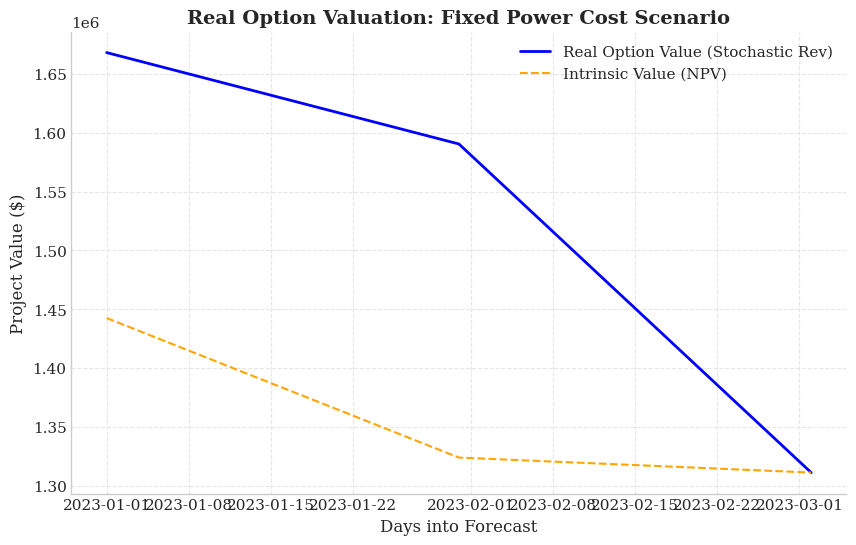

In [25]:
df_ro_fixed = results_fixed[0] # Option Value
df_int_fixed = results_fixed[2] # Intrinsic Value (NPV)

# 5. Visualize Results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Mean Option Value vs Mean Intrinsic Value over time
ax.plot(df_ro_fixed.mean(axis=0), label="Real Option Value (Stochastic Rev)", color='blue', linewidth=2)
ax.plot(df_int_fixed.mean(axis=0), label="Intrinsic Value (NPV)", color='orange', linestyle='--')

ax.set_title("Real Option Valuation: Fixed Power Cost Scenario")
ax.set_ylabel("Project Value ($)")
ax.set_xlabel("Days into Forecast")
ax.legend()

export_figure(fig, "ro_value_fixed_cost")

# 6. Export Key Metrics
ro_val_t0 = df_ro_fixed.iloc[0, 0]
int_val_t0 = df_int_fixed.iloc[0, 0]
option_premium = ro_val_t0 - int_val_t0

fixed_cost_results = {
    "FixedPowerROValue": f"{ro_val_t0:,.0f}",
    "FixedPowerNPV": f"{int_val_t0:,.0f}",
    "FixedPowerPremium": f"{option_premium:,.0f}"
}
export_params(fixed_cost_results, "ro_results_fixed")

print(f"--- Results (Fixed Power) ---")
print(f"Real Option Value: ${ro_val_t0:,.0f}")
print(f"Intrinsic NPV:     ${int_val_t0:,.0f}")
print(f"Option Premium:    ${option_premium:,.0f} (Value of Flexibility)")

### 4. Final Discussion

Here the final discussion